# Anime DCGAN

Generate new Anime caracters using DCGAN.

### Import thz librairies

In [ ]:
!pip install skillsnetwork

In [3]:
import warnings
warnings.simplefilter('ignore')

import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm


tensorflow version: 2.18.0
skillsnetwork version: 0.21.10


function to display 5 images

In [23]:
def plot_array(X, title=""):
  plt.rcParams['figure.figsize']= (20,20)
  # X[0] selects the first batch from the dataset
  # Iterate through the first 5 images of the batch
  for i,x in enumerate(X[0][0:5]):
    x = x.numpy()
    max = x.max()
    min = x.min()
    xnew = np.uint(255 *(x-min)/(max-min))
    plt.subplot(1,5,i+1)
    plt.imshow(xnew)
    plt.axis("off")

  plt.title(title)
  plt.show()

## load dataset

In [5]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

Saved to '.'


## Creating the dataset based on the dataset_url

In [6]:
img_height, img_width, batch_size=64,64,128

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000',
                                                       image_size=(img_height,img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)

Found 20000 files.


## Normalize the pixel values of all the input images

In [57]:
normalization_layer = tf.keras.layers.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

take a one batch to display

In [58]:
images=train_ds.take(1)

In [59]:
X = [x for x in images]

plot the first image

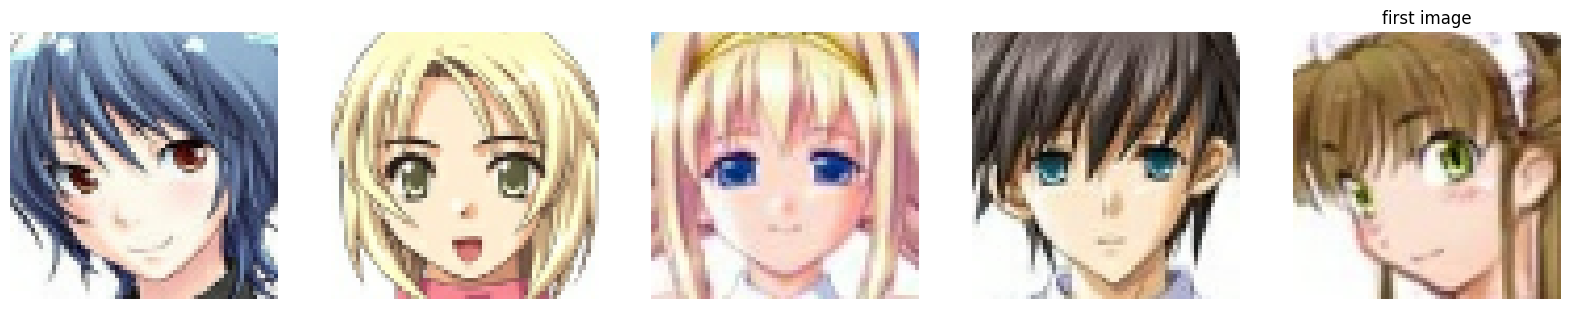

In [60]:
plot_array(X, title="first image")

##  Generator and Discriminator


#### Generator

The Generator is comprised of several layers of transposed convolution, the opposite of convolution operations.

- Each Conv2DTranspose layer (except the final layer) is followed by a Batch Normalization layer and a **Relu activation**; for more implementation details, check out <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">[1]</a>.
- The final transpose convolution layer has three output channels since the output needs to be a color image. We use the **Tanh activation** in the final layer.

See the illustration of the architecture from <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">[1]</a> below.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.png" alt="generator image" width="80%"></center>

We build the Generator network by using the parameter values from <a href="https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" >[2]<a>.


In [62]:
def make_generator():

    model=Sequential()

    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))

    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))


    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                              activation='tanh', name='conv_transpose_5'))

    return model

In [63]:
gen = make_generator()
gen.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_transpose_1                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_2                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_3                │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_4                │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_5                │ (None, 64, 64, 3)      │         3,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,578,624 (13.65 MB)

 Trainable params: 3,576,704 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

The Discriminator has five convolution layers.

- All but the first and final Conv2D layers have Batch Normalization, since directly applying batchnorm to all layers could result in sample oscillation and model instability;
- The first four Conv2D layers use the **Leaky-Relu activation** with a slope of 0.2.
- Lastly, instead of a fully connected layer, the  output layer has a convolution layer with a **Sigmoid activation** function.


In [64]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

In [65]:
disc = make_discriminator()
disc.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyReLU)        │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 2, 2, 1)        │         8,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,360 (10.56 MB)

 Trainable params: 2,765,568 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Define Loss function

In [66]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [67]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [68]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

## Defining optimizers

In [69]:
learning_rate = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

## Train step function

In [70]:
## to compile the function into a tenserflow graph
@tf.function

def train_step(X):

    #generates a batch of random noise vectors (z). These vectors are the input
    #to the generator. latent_dim represents the dimensionality of the latent space (the space where the random noise vectors live).
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)

        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

- First, we sample `z`, a batch of noise vectors from a normal distribution ($\mu = 1, \sigma = 1$) and feed it to the Generator.
- The Generator produces generated or "fake" images `xhat`.
- We feed real images `X` and fake images `xhat` to the Discriminator and obtain `real_output` and `fake_output` respectively as the scores.
- We calculate Generator loss `gen_loss` using the `fake_output` from Discriminator since we want the fake images to fool the Discriminator as much as possible.
- We calculate Discriminator loss `disc_loss` using both the `real_output` and `fake_output` since we want the Discriminator to distinguish the two as much as possible.
- We calculate `gradients_of_generator` and  `gradients_of_discriminator` based on the losses obtained.
- Finally, we update the Generator and Discriminator by letting their respective optimizers apply the processed gradients on the trainable model parameters.

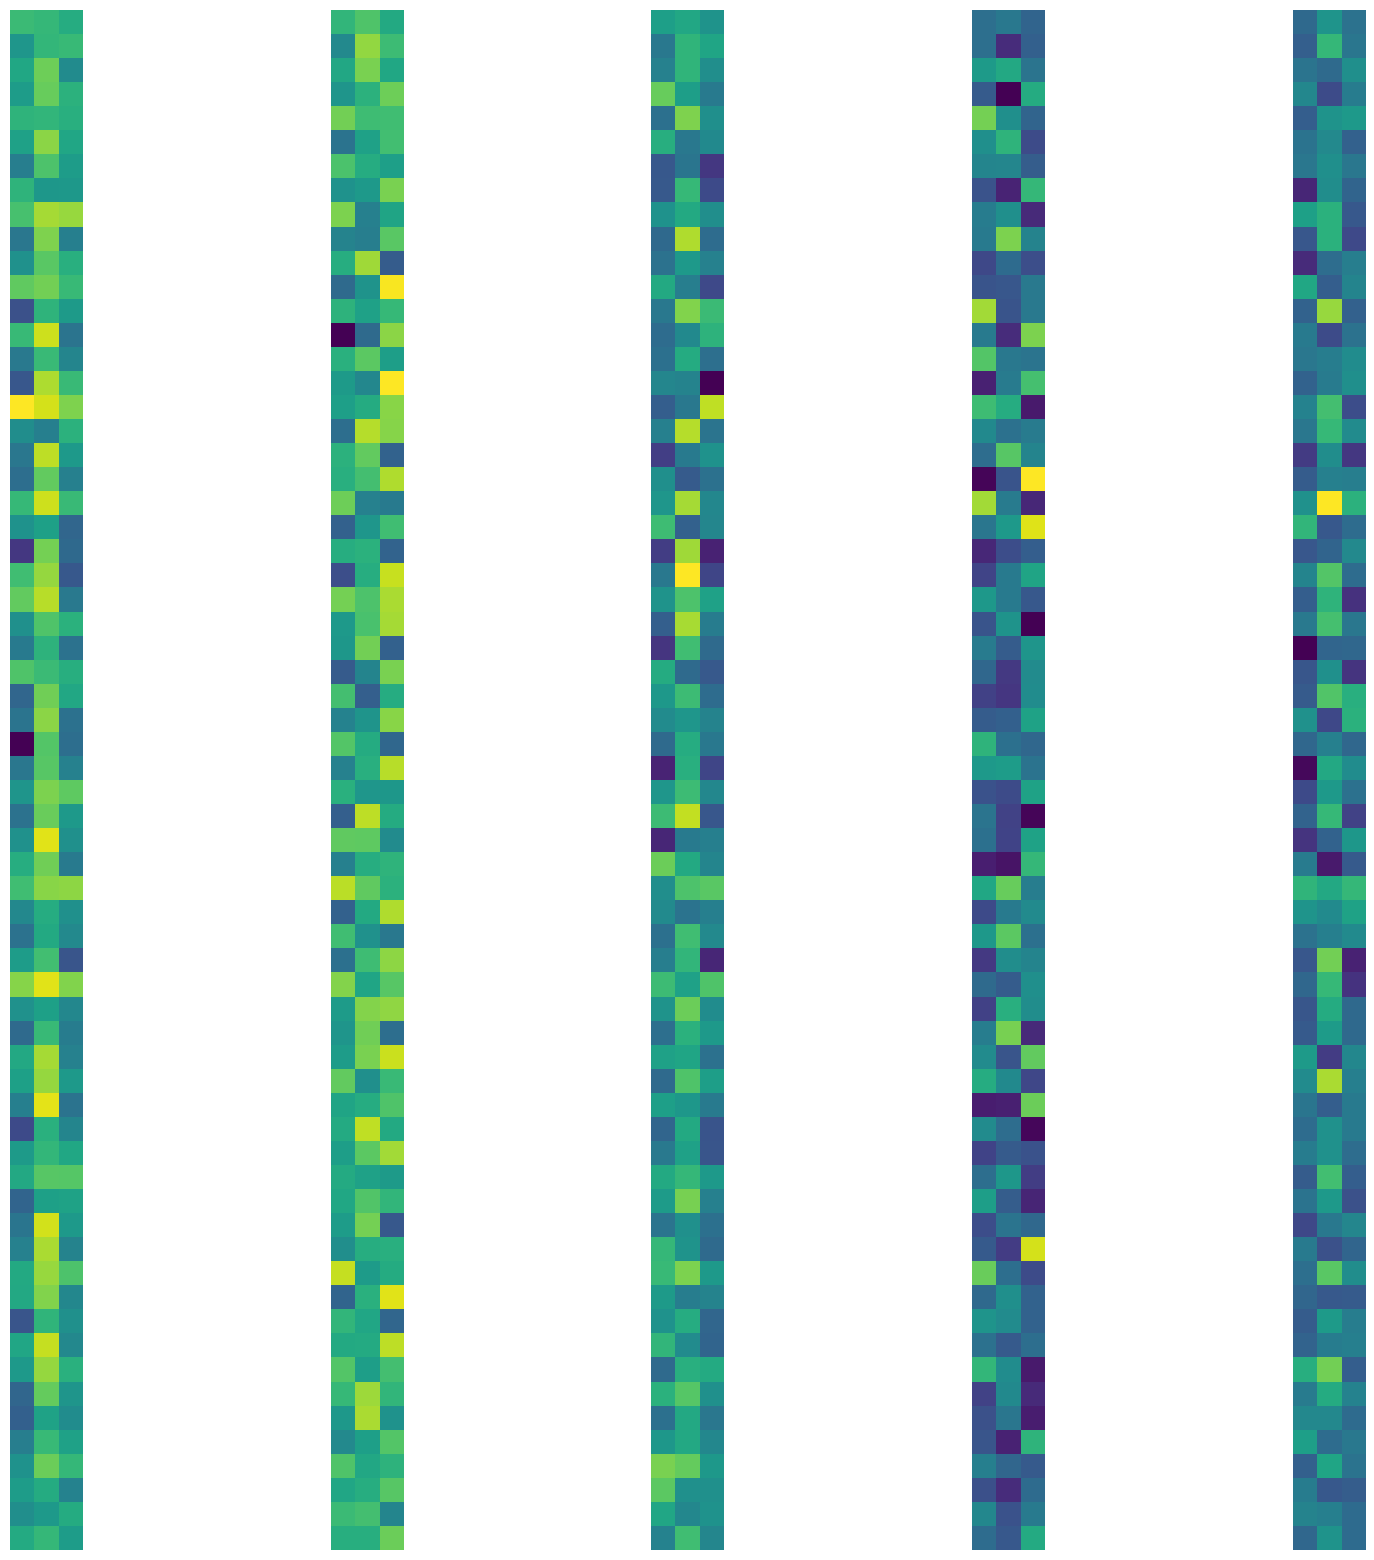

In [71]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

## Train the model

Epoch 1/1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch1 iteration1
epoch1 iteration2
epoch1 iteration3
epoch1 iteration4
epoch1 iteration5
epoch1 iteration6
epoch1 iteration7
epoch1 iteration8
epoch1 iteration9
epoch1 iteration10
epoch1 iteration11
epoch1 iteration12
epoch1 iteration13
epoch1 iteration14
epoch1 iteration15
epoch1 iteration16
epoch1 iteration17
epoch1 iteration18
epoch1 iteration19
epoch1 iteration20
epoch1 iteration21
epoch1 iteration22
epoch1 iteration23
epoch1 iteration24
epoch1 iteration25
epoch1 iteration26
epoch1 iteration27
epoch1 iteration28
epoch1 iteration29
epoch1 iteration30
epoch1 iteration31
epoch1 iteration32
epoch1 iteration33
epoch1 iteration34
epoch1 iteration35
epoch1 iteration36
epoch1 iteration37
epoch1 iteration38
epoch1 iteration39
epoch1 iteration40
epoch1 iteration41
epoch1 iteration42
epoch1 iteration43
epoch1 iteration44
epoch1 iteration45
epoch1 iteration46
epoch1 iteration47
epoch1 iteration48
epoch1 iteration49
epoch1 iteration50
epoch1 iteration51
epoch1 iteration52
epoch1 iteration53
ep

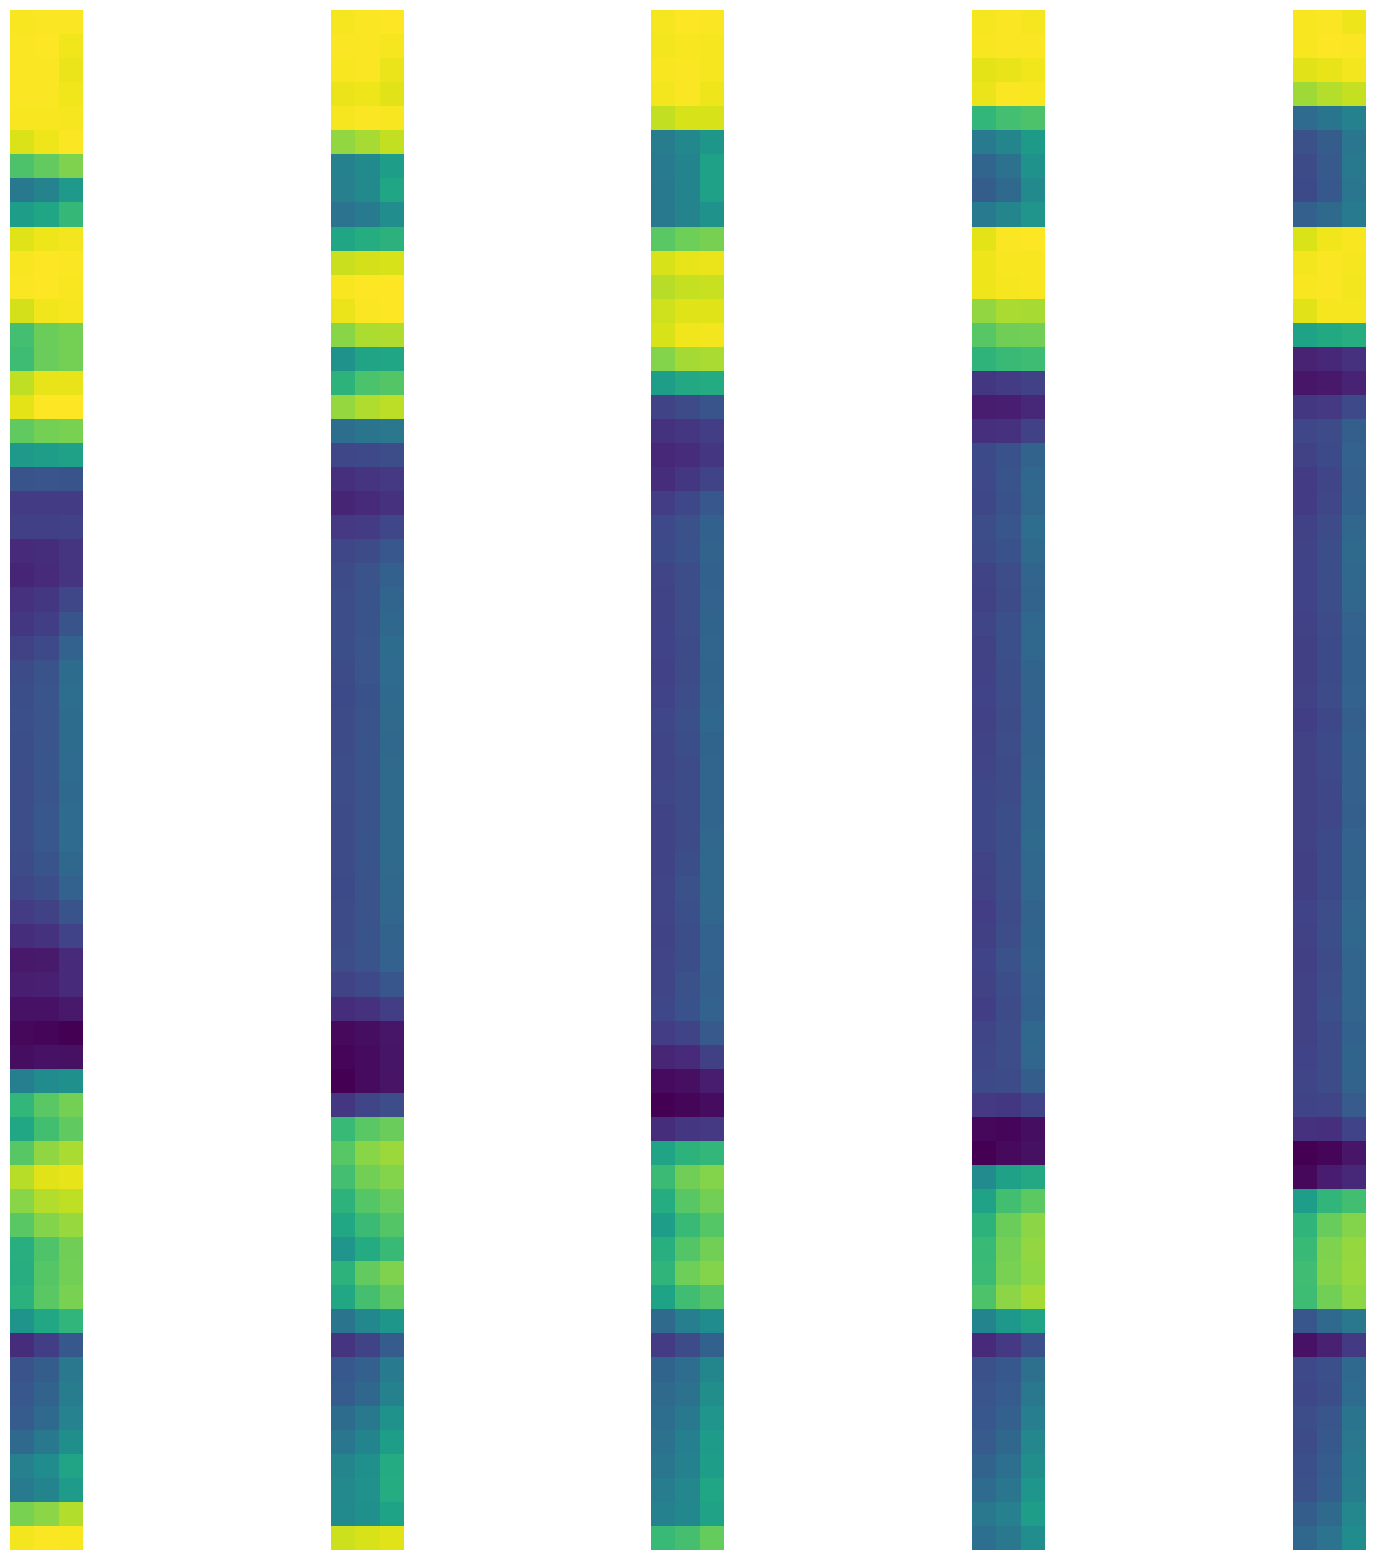

generated images


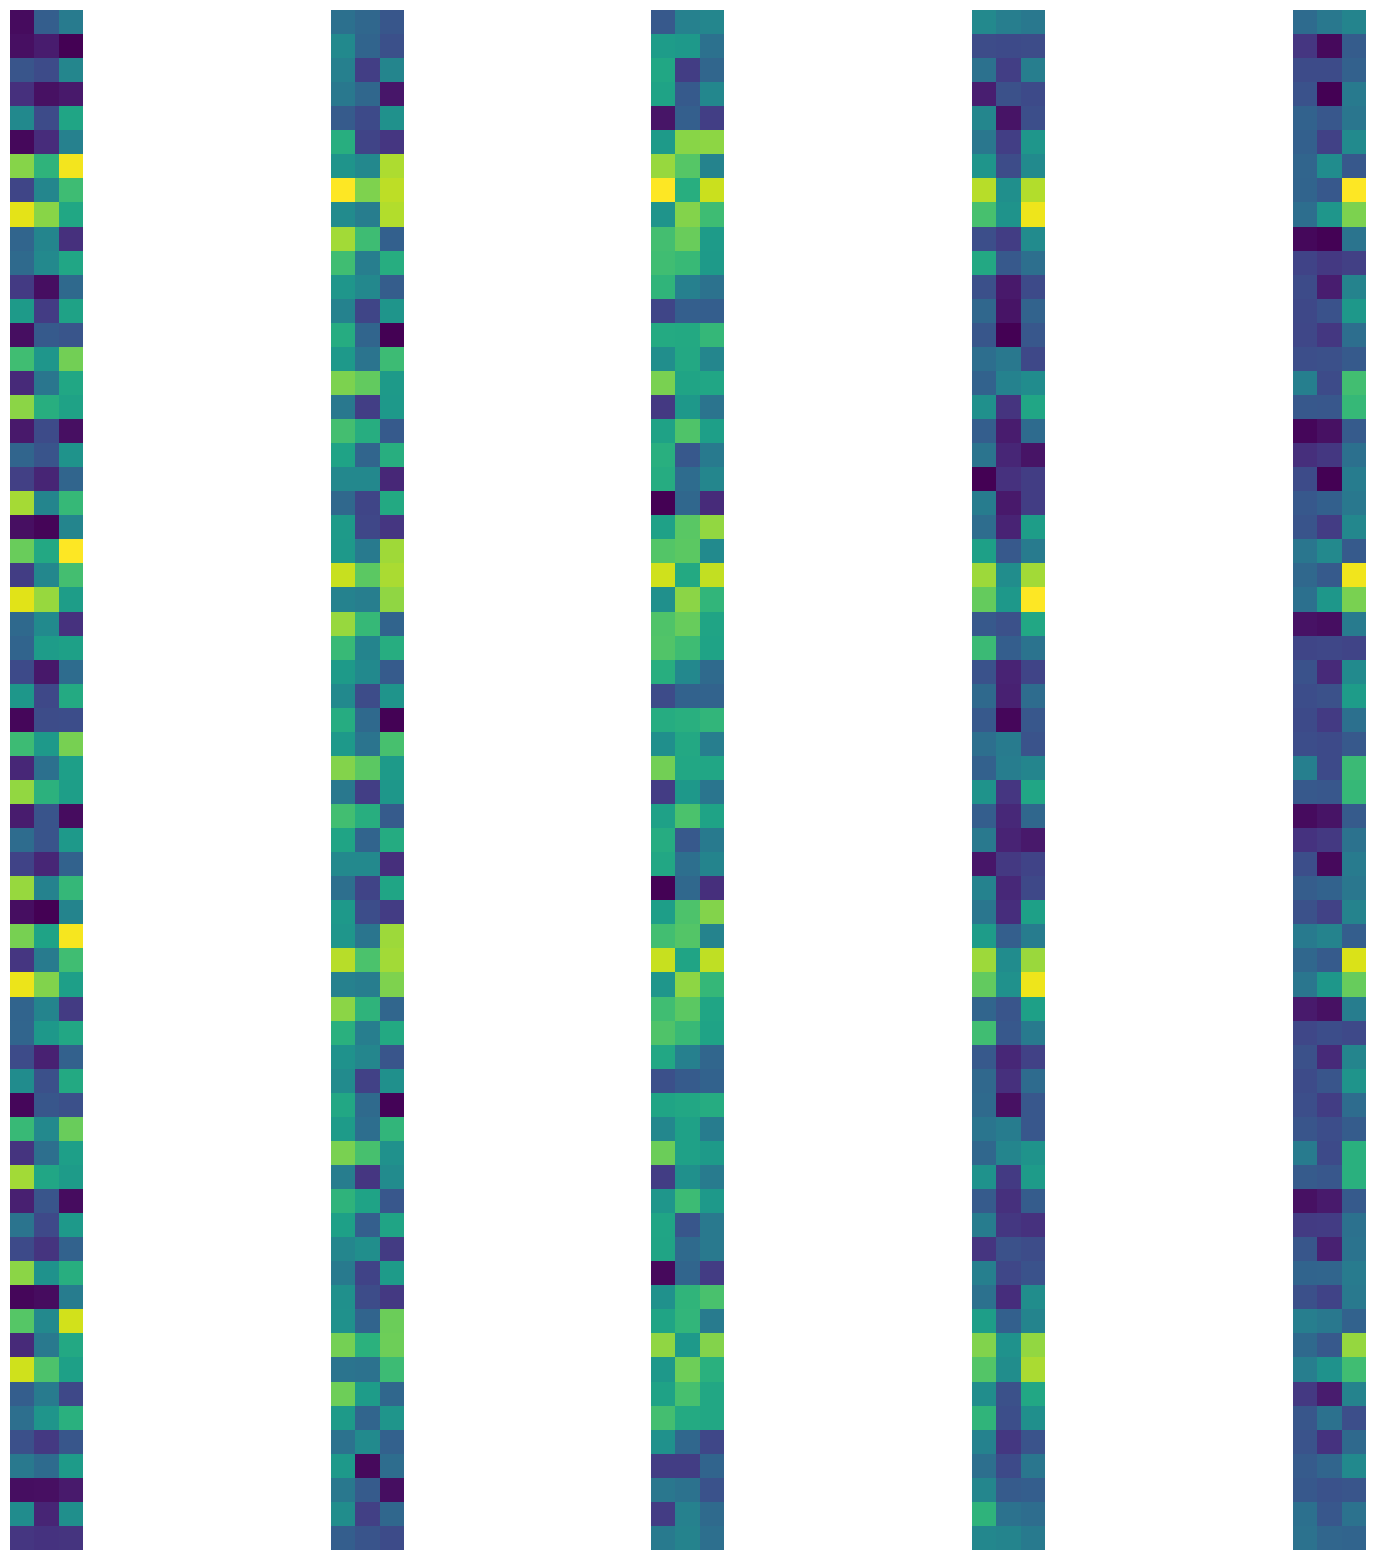

Time for epoch 1 is 1413.3101868629456 sec


In [38]:
epochs = 1
generator = make_generator()
discriminator = make_discriminator()
for epoch in range(epochs):
  #data for the true distribution of the real data samples training ste
  start = time.time()
  i = 0
  for X in tqdm(normalized_ds, desc=f"Epoch {epoch+1}/{epochs}", total=len(normalized_ds)):
    i+=1
    if i%1000:
      print("epoch{} iteration{}".format(epoch+1,i))
    train_step(X)
  noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
  Xhat=generator(noise,training=False)
  X=[x for x in normalized_ds]
  print("orignal images")
  plot_array(X[0])
  print("generated images")
  plot_array(Xhat)
  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))